In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel
import torch


In [20]:
df = pd.read_csv("Data/translations_scored.csv")

In [6]:
score_cols = [
    'Google translation_bleurt', 'Google translation_comet', 'cosine_Google_translation',
    'Microsoft translation_bleurt', 'Microsoft translation_comet', 'cosine_Microsoft_translation',
    'DeepL translation_bleurt', 'DeepL translation_comet', 'cosine_DeepL_translation'
]

In [14]:
model_configs = {
    "Google": {
        "bleurt":  "Google translation_bleurt",
        "comet":   "Google translation_comet",
        "cosine":  "cosine_Google_translation",
    },
    "Microsoft": {
        "bleurt":  "Microsoft translation_bleurt",
        "comet":   "Microsoft translation_comet",
        "cosine":  "cosine_Microsoft_translation",
    },
    "DeepL": {
        "bleurt":  "DeepL translation_bleurt",
        "comet":   "DeepL translation_comet",
        "cosine":  "cosine_DeepL_translation",
    },
}



=== Google: IsolationForest outliers ===


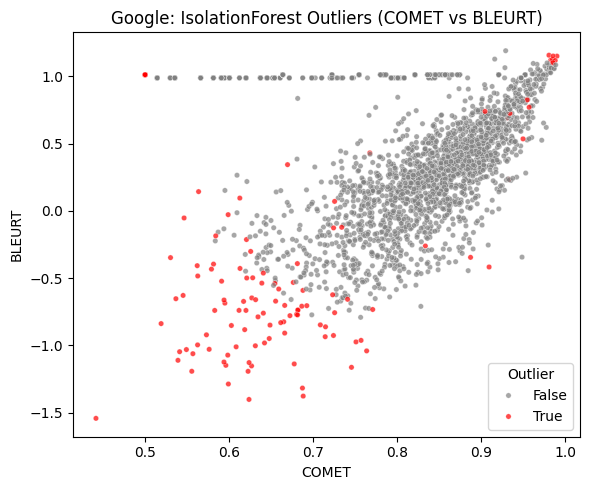


=== Microsoft: IsolationForest outliers ===


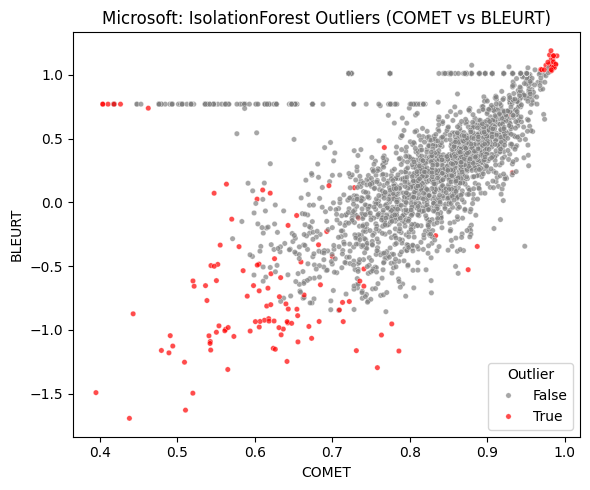


=== DeepL: IsolationForest outliers ===


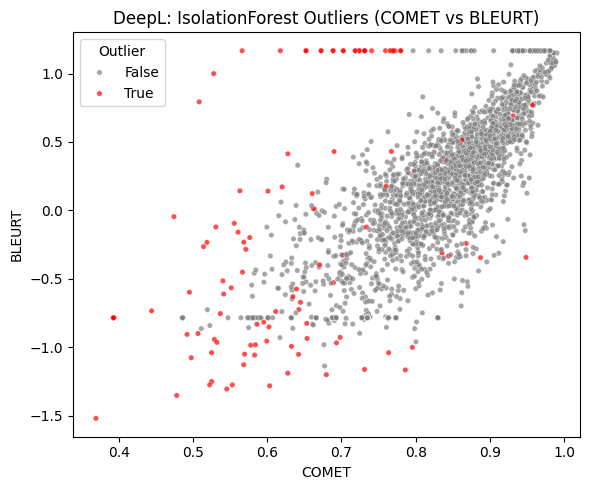

In [31]:
for name, cfg in model_configs.items():
    print(f"\n=== {name}: IsolationForest outliers ===")
    
    cols = [cfg["bleurt"], cfg["comet"], cfg["cosine"]]
    X = df[cols].copy()
    X = X.fillna(X.mean())  # simple handling of NaNs
    
    iso = IsolationForest(contamination=0.05, random_state=42)
    labels = iso.fit_predict(X)    # -1 = outlier, 1 = inlier
    
    out_col = f"{name}_iso_outlier"
    df[out_col] = labels
    
    # Simple 2D plot: COMET vs BLEURT, colored by outlier
    df[f"{name}_is_outlier"] = df[out_col] == -1
    
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=df,
        x=cfg["comet"],
        y=cfg["bleurt"],
        hue=f"{name}_is_outlier",
        palette={False: "grey", True: "red"},
        alpha=0.7,
        s=15,
    )
    plt.title(f"{name}: IsolationForest Outliers (COMET vs BLEURT)")
    plt.xlabel("COMET")
    plt.ylabel("BLEURT")
    plt.legend(title="Outlier")
    plt.tight_layout()
    plt.savefig(f"figs/{name}iso_COMETvsBLEURT.png") 
    plt.show()


In [24]:
df.head()


,korean,actual translation,Google translation,Microsoft translation,DeepL translation,Google translation_bleurt,Google translation_comet,Microsoft translation_bleurt,Microsoft translation_comet,DeepL translation_bleurt,...,cosine_Google_translation,cosine_Microsoft_translation,cosine_DeepL_translation,outlier_iso,Google_iso_outlier,Google_is_outlier,Microsoft_iso_outlier,Microsoft_is_outlier,DeepL_iso_outlier,DeepL_is_outlier
0,아직 3분 시작된 건 아니죠? 그렇죠?,"My three minutes hasn't started yet, has it?","The 3 minutes haven't started yet, right? Right?","It's not three minutes yet, right? Right?","It's not quite three minutes in yet, is it?",0.109180,0.856831,-0.223568,0.760674,0.215006,...,0.912729,0.814388,0.827700,1,1,False,1,False,1,False
1,"네, 맘대로 시작하실 수 없습니다.","No, you can't start the three minutes.","Yes, you can't start it however you want.","Yes, you can't start as you want.","Yes, you can't just start at will.",-0.179017,0.744170,-0.173276,0.773100,-0.462301,...,0.637112,0.684821,0.549571,1,1,False,1,False,1,False
2,"3분 다시 설정해주세요, 이건 반칙입니다.","Reset the three minutes, that's just not fair.","Please reset the time to 3 minutes, this is a ...","Please set it again for 3 minutes, this is a f...","Please reset the 3 minutes, this is cheating.",-0.579378,0.783946,-0.773436,0.746450,-0.475596,...,0.660077,0.531548,0.631793,1,1,False,1,False,1,False
3,"어머나, 여기 참 냉정하네요","Oh my God, it's harsh up here.","Oh my, it's so cold in here.","Oh my God, it's so cold here","My goodness, this place is cold.",-0.456702,0.824750,-0.527967,0.875555,-0.204798,...,0.526661,0.523677,0.482740,1,1,False,-1,True,1,False
4,정말이지 긴장되네요,I mean I'm nervous enough as it is.,I'm really nervous.,I'm really nervous,I'm really nervous,0.443310,0.815813,0.396191,0.808104,0.396191,...,0.849992,0.843571,0.843571,1,1,False,1,False,1,False


In [27]:
from sklearn.decomposition import PCA



=== Google: KMeans + PCA ===


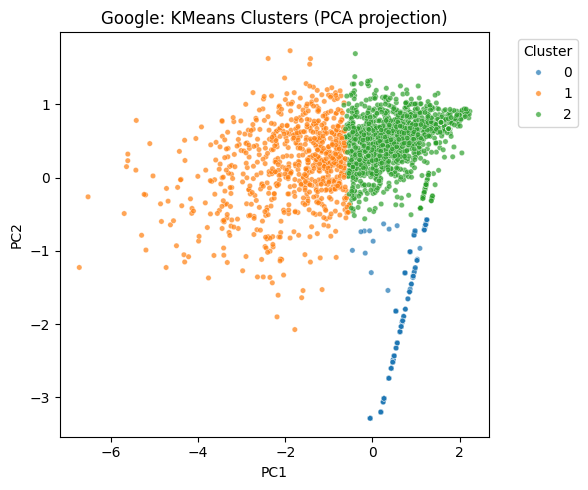


=== Microsoft: KMeans + PCA ===


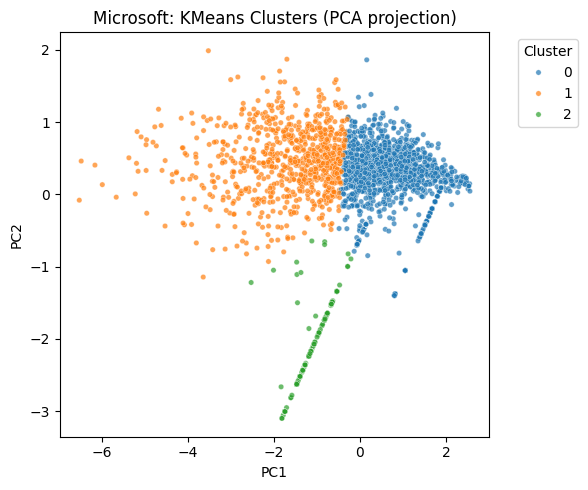


=== DeepL: KMeans + PCA ===


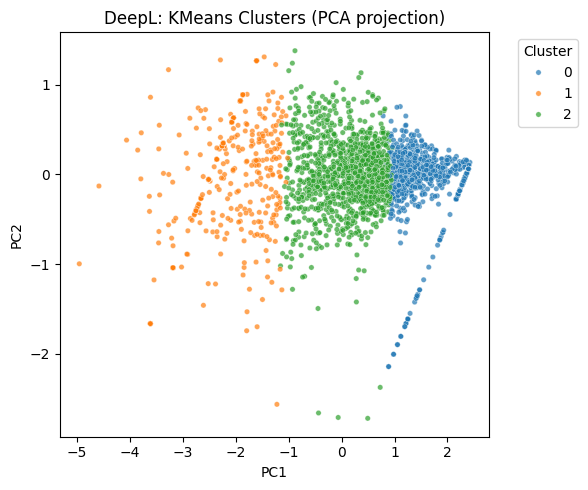

In [32]:
for name, cfg in model_configs.items():
    print(f"\n=== {name}: KMeans + PCA ===")
    
    cols = [cfg["bleurt"], cfg["comet"], cfg["cosine"]]
    X = df[cols].copy().fillna(df[cols].mean())
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # KMeans
    kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(X_scaled)
    df[f"{name}_cluster"] = clusters
    
    # PCA to 2D for visualization
    pca = PCA(n_components=2, random_state=42)
    pcs = pca.fit_transform(X_scaled)
    df[f"{name}_pc1"] = pcs[:, 0]
    df[f"{name}_pc2"] = pcs[:, 1]
    
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=df,
        x=f"{name}_pc1",
        y=f"{name}_pc2",
        hue=f"{name}_cluster",
        palette="tab10",
        s=15,
        alpha=0.7,
    )
    plt.title(f"{name}: KMeans Clusters (PCA projection)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.savefig(f"figs/{name}KmeansClusters.png") 
    plt.show()



=== Google: LOF outliers ===


/Users/Hawraa_1/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


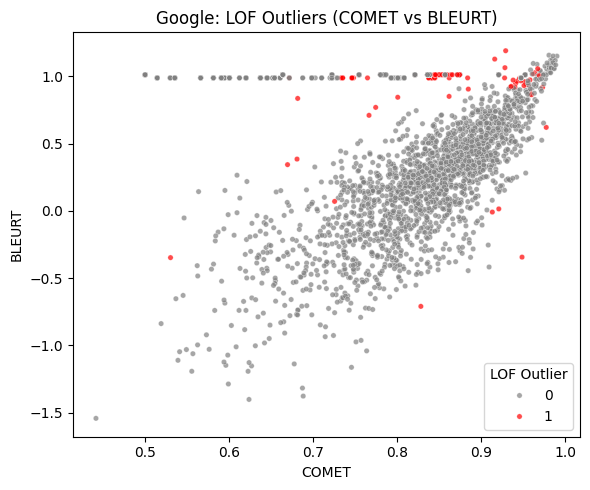


=== Microsoft: LOF outliers ===


/Users/Hawraa_1/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


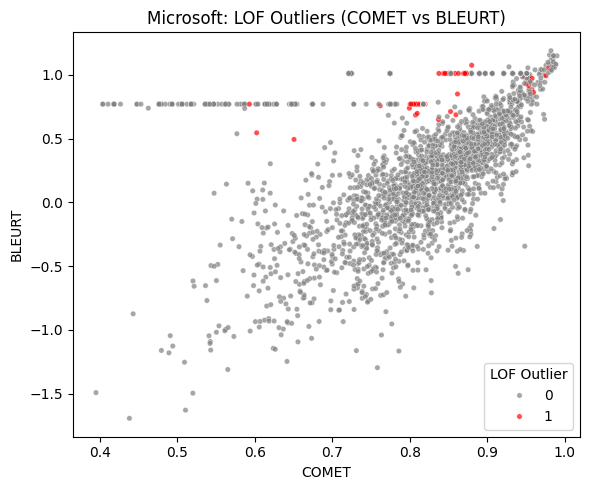


=== DeepL: LOF outliers ===


/Users/Hawraa_1/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


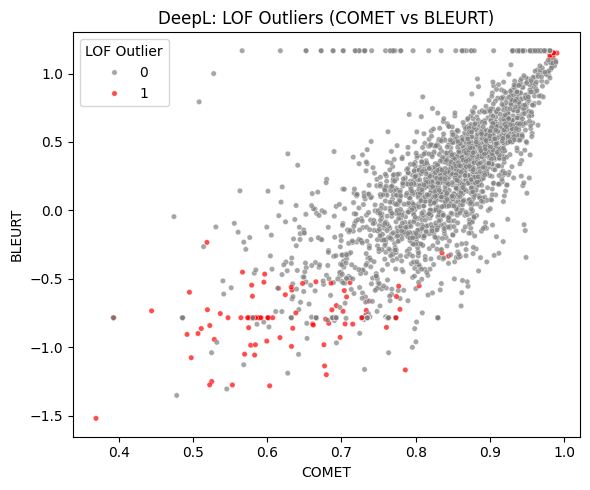

In [33]:
for name, cfg in model_configs.items():
    print(f"\n=== {name}: LOF outliers ===")
    
    cols = [cfg["bleurt"], cfg["comet"], cfg["cosine"]]
    X = df[cols].copy().fillna(df[cols].mean())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.05,
    )
    lof_labels = lof.fit_predict(X_scaled)   # -1 outlier, 1 inlier
    lof_scores = lof.negative_outlier_factor_
    
    df[f"{name}_lof_outlier"] = (lof_labels == -1).astype(int)
    df[f"{name}_lof_score"] = lof_scores
    
    # Plot: COMET vs BLEURT, colored by LOF outlier
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=df,
        x=cfg["comet"],
        y=cfg["bleurt"],
        hue=f"{name}_lof_outlier",
        palette={0: "grey", 1: "red"},
        alpha=0.7,
        s=15,
    )
    plt.title(f"{name}: LOF Outliers (COMET vs BLEURT)")
    plt.xlabel("COMET")
    plt.ylabel("BLEURT")
    plt.legend(title="LOF Outlier")
    plt.tight_layout()
    plt.savefig(f"figs/{name}LOFOutliers.png") 
    plt.show()



=== PCA for Google ===


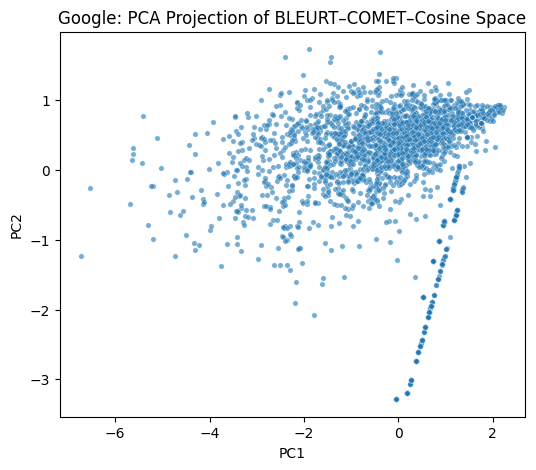


=== PCA for Microsoft ===


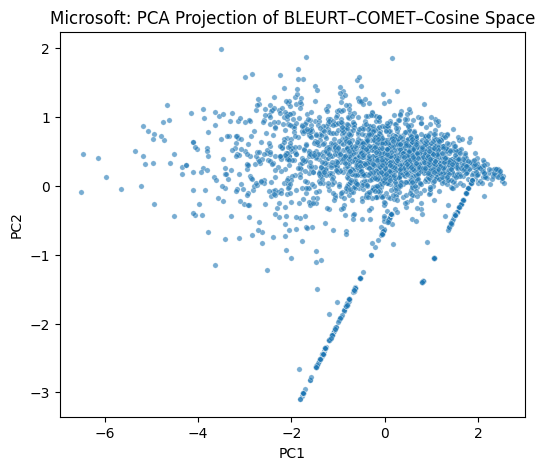


=== PCA for DeepL ===


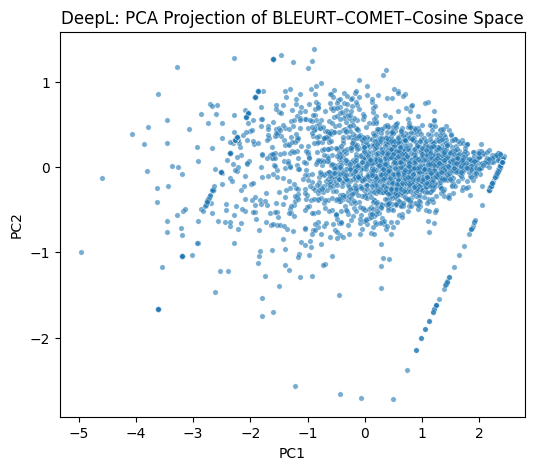

In [ ]:
for name, cfg in model_configs.items():
    print(f"\n=== PCA for {name} ===")

    cols = [cfg["bleurt"], cfg["comet"], cfg["cosine"]]
    X = df[cols].copy().fillna(df[cols].mean())

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2, random_state=42)
    pcs = pca.fit_transform(X_scaled)

    df[f"{name}_pc1"] = pcs[:, 0]
    df[f"{name}_pc2"] = pcs[:, 1]

    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=df,
        x=f"{name}_pc1",
        y=f"{name}_pc2",
        s=15,
        alpha=0.6,
    )
    plt.title(f"{name}: PCA Projection of BLEURT–COMET–Cosine Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    plt.show()



In [40]:
long_df = pd.DataFrame()

for name, cfg in model_configs.items():
    tmp = df[[cfg["bleurt"], cfg["comet"], cfg["cosine"]]].copy()
    tmp.columns = ["bleurt", "comet", "cosine"]
    tmp["model"] = name
    long_df = pd.concat([long_df, tmp], axis=0)



In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(long_df[["bleurt","comet","cosine"]])

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

long_df["pc1"] = pcs[:, 0]
long_df["pc2"] = pcs[:, 1]


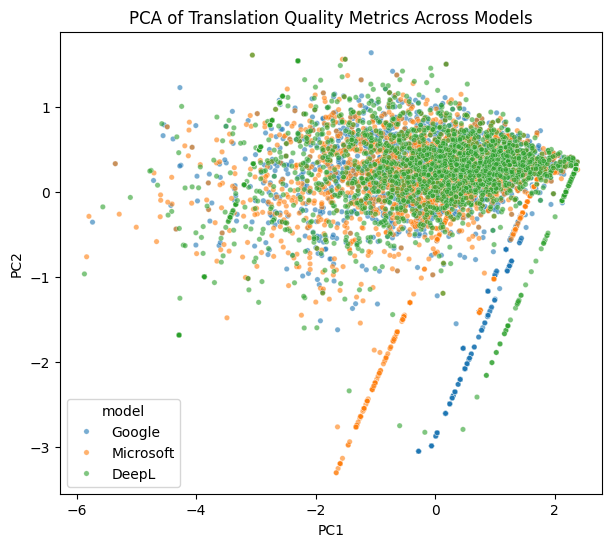

In [42]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=long_df,
    x="pc1",
    y="pc2",
    hue="model",
    s=15,
    alpha=0.6
)
plt.title("PCA of Translation Quality Metrics Across Models")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig(f"figs/PCA.png") 
plt.show()


In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for name, cfg in model_configs.items():
    df[cfg["bleurt"] + "_norm"] = scaler.fit_transform(df[[cfg["bleurt"]]])
    df[cfg["comet"] + "_norm"]  = scaler.fit_transform(df[[cfg["comet"]]])
    df[cfg["cosine"] + "_norm"] = scaler.fit_transform(df[[cfg["cosine"]]])


In [49]:
qe_weights = {"comet": 0.6, "bleurt": 0.2, "cosine": 0.2}

for name, cfg in model_configs.items():
    bleurt_n = cfg["bleurt"] + "_norm"
    comet_n  = cfg["comet"] + "_norm"
    cosine_n = cfg["cosine"] + "_norm"
    
    df[f"{name}_QE"] = (
        qe_weights["comet"]  * df[comet_n] +
        qe_weights["bleurt"] * df[bleurt_n] +
        qe_weights["cosine"] * df[cosine_n]
    )


In [52]:
for name in model_configs:
    df[f"{name}_loss"] = 1 - df[f"{name}_QE"]




=== Google: error cases (low COMET, high pseudo-loss) ===
Google_error_case
False    2244
True      577
Name: count, dtype: int64


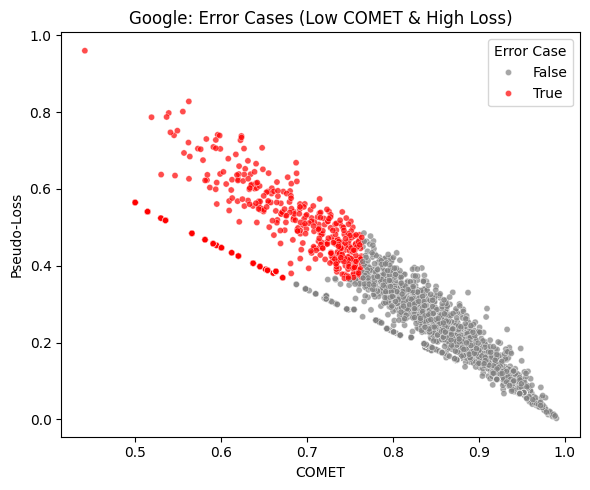


=== Microsoft: error cases (low COMET, high pseudo-loss) ===
Microsoft_error_case
False    2210
True      611
Name: count, dtype: int64


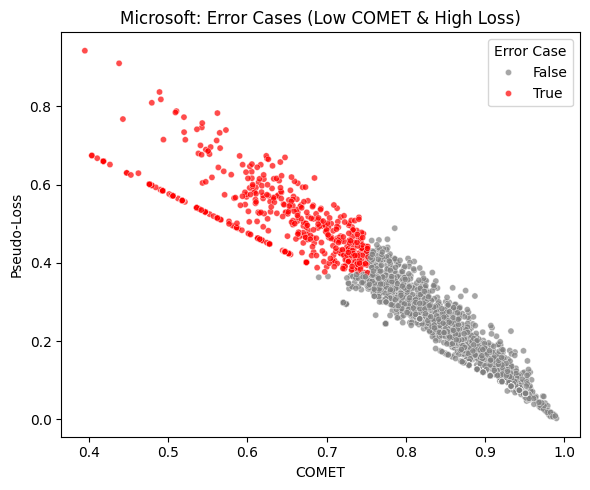


=== DeepL: error cases (low COMET, high pseudo-loss) ===
DeepL_error_case
False    2219
True      602
Name: count, dtype: int64


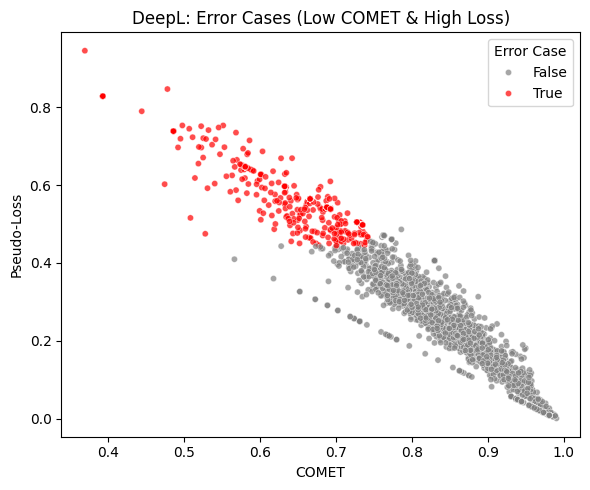

In [54]:
for name, cfg in model_configs.items():
    comet_col = cfg["comet"]
    loss_col = f"{name}_loss"
    
    comet_q25 = df[comet_col].quantile(0.25)    # low-quality region
    loss_q75  = df[loss_col].quantile(0.75)     # high-error region
    
    err_col = f"{name}_error_case"
    df[err_col] = (
        (df[comet_col] <= comet_q25) &
        (df[loss_col]  >= loss_q75)
    )
    
    print(f"\n=== {name}: error cases (low COMET, high pseudo-loss) ===")
    print(df[err_col].value_counts())

    # Visualization
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        data=df,
        x=comet_col,
        y=loss_col,
        hue=err_col,
        palette={False: "grey", True: "red"},
        alpha=0.7,
        s=20
    )
    plt.title(f"{name}: Error Cases (Low COMET & High Loss)")
    plt.xlabel("COMET")
    plt.ylabel("Pseudo-Loss")
    plt.legend(title="Error Case")
    plt.tight_layout()
    plt.savefig(f"figs/{name}Loss.png") 
    plt.show()
